# Measuremets
This notebook summarizes and plots all the details about the measurements taken for storm and gas.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [3]:
data_file = 'drive/My Drive/Expenses/measurements.csv'
data = pd.read_csv(data_file)
data

,aggregate_consumption,date,type,measure_unit,currency,unit_price
0,54149.600,2019-09-23 18:37:00,Storm,kWh,EUR,0.23
1,54157.600,2019-09-29 16:23:00,Storm,kWh,EUR,0.23
2,44.633,2019-10-05 13:54:00,Gas,mWh,EUR,63.20
3,54161.800,2019-10-08 16:36:00,Storm,kWh,EUR,0.23
4,54175.100,2019-10-19 10:02:00,Storm,kWh,EUR,0.23
5,44.716,2019-10-28 13:57:00,Gas,mWh,EUR,63.20
6,54219.800,2019-10-29 20:17:00,Storm,kWh,EUR,0.23
7,54277.000,2019-11-08 18:00:00,Storm,kWh,EUR,0.23
8,0.000,2019-11-08 18:00:00,Storm,kWh,EUR,0.23
9,107.000,2019-11-24 20:00:00,Storm,kWh,EUR,0.23


## Preprocessing
### Period Consumption from Aggregate Consumption
The `aggregate_consumption` column is aggregate consumption so we need to calculate period `consumption`. Also calculate how long is the 

In [4]:
dfs = []
for type_v in data.type.unique():
  df = data[data.type == type_v].copy()

  # Fix the restarts
  aggregate_consumption = df['aggregate_consumption']
  zeros = df.index[aggregate_consumption == 0]
  for zero in zeros:
    df.loc[zero:,'aggregate_consumption'] += aggregate_consumption[zero - 1]

  # Fix the initial consumption
  df['aggregate_consumption'] -= df.aggregate_consumption.min()

  aggregate_consumption = df.aggregate_consumption.to_numpy()
  date = df['date'].to_numpy()
  # Add the first element twice because we don't have measurement before, consumption here should be 0. Also remove the last element because we don't have to substract it from anything
  aggregate_consumption_shifted = np.concatenate(([aggregate_consumption[0]], aggregate_consumption))[0:-1]
  date_shifted = np.concatenate(([date[0]], date))[0:-1]
  # substract the aggregated consumption and the shifted aggregated consumption. Moreover, set min to 0 to handle any resets to the measurement unit.
  df['consumption'] = (aggregate_consumption - aggregate_consumption_shifted).clip(min=0)
  df['from_date'] = pd.to_datetime(date_shifted)
  to_date = pd.to_datetime(date)
  df['to_date'] = to_date
  timedelta = pd.to_timedelta(df.to_date - df.from_date)
  df['timedelta'] = timedelta
  df['seconds'] = timedelta.dt.total_seconds()
  df.drop(['date'], axis=1, inplace=True)
  # is_in = df['consumption'] != 0
  # is_in[df.index[0]] = True
  # df = df[is_in].copy()
  df = df.set_index('to_date', drop=False, append=False, inplace=False, verify_integrity=False)
  dfs.append(df)

df = pd.concat(dfs, axis=0).sort_index()
df

,aggregate_consumption,type,measure_unit,currency,unit_price,consumption,from_date,to_date,timedelta,seconds
to_date,,,,,,,,,,
2019-09-23 18:37:00.000000,0.000,Storm,kWh,EUR,0.23,0.000,2019-09-23 18:37:00.000000,2019-09-23 18:37:00.000000,0 days 00:00:00,0.000000e+00
2019-09-29 16:23:00.000000,8.000,Storm,kWh,EUR,0.23,8.000,2019-09-23 18:37:00.000000,2019-09-29 16:23:00.000000,5 days 21:46:00,5.103600e+05
2019-10-05 13:54:00.000000,0.000,Gas,mWh,EUR,63.20,0.000,2019-10-05 13:54:00.000000,2019-10-05 13:54:00.000000,0 days 00:00:00,0.000000e+00
2019-10-08 16:36:00.000000,12.200,Storm,kWh,EUR,0.23,4.200,2019-09-29 16:23:00.000000,2019-10-08 16:36:00.000000,9 days 00:13:00,7.783800e+05
2019-10-19 10:02:00.000000,25.500,Storm,kWh,EUR,0.23,13.300,2019-10-08 16:36:00.000000,2019-10-19 10:02:00.000000,10 days 17:26:00,9.267600e+05
2019-10-28 13:57:00.000000,0.083,Gas,mWh,EUR,63.20,0.083,2019-10-05 13:54:00.000000,2019-10-28 13:57:00.000000,23 days 00:03:00,1.987380e+06
2019-10-29 20:17:00.000000,70.200,Storm,kWh,EUR,0.23,44.700,2019-10-19 10:02:00.000000,2019-10-29 20:17:00.000000,10 days 10:15:00,9.009000e+05
2019-11-08 18:00:00.000000,127.400,Storm,kWh,EUR,0.23,57.200,2019-10-29 20:17:00.000000,2019-11-08 18:00:00.000000,9 days 21:43:00,8.557800e+05
2019-11-08 18:00:00.000000,127.400,Storm,kWh,EUR,0.23,0.000,2019-11-08 18:00:00.000000,2019-11-08 18:00:00.000000,0 days 00:00:00,0.000000e+00


### Calculate the price of the measurements

In [5]:
df['price'] = df['consumption'] * df['unit_price']
df['aggregated_price'] = df['aggregate_consumption'] * df['unit_price']
df['seconds'] = df['timedelta'].dt.total_seconds()
df

,aggregate_consumption,type,measure_unit,currency,unit_price,consumption,from_date,to_date,timedelta,seconds,price,aggregated_price
to_date,,,,,,,,,,,,
2019-09-23 18:37:00.000000,0.000,Storm,kWh,EUR,0.23,0.000,2019-09-23 18:37:00.000000,2019-09-23 18:37:00.000000,0 days 00:00:00,0.000000e+00,0.0000,0.0000
2019-09-29 16:23:00.000000,8.000,Storm,kWh,EUR,0.23,8.000,2019-09-23 18:37:00.000000,2019-09-29 16:23:00.000000,5 days 21:46:00,5.103600e+05,1.8400,1.8400
2019-10-05 13:54:00.000000,0.000,Gas,mWh,EUR,63.20,0.000,2019-10-05 13:54:00.000000,2019-10-05 13:54:00.000000,0 days 00:00:00,0.000000e+00,0.0000,0.0000
2019-10-08 16:36:00.000000,12.200,Storm,kWh,EUR,0.23,4.200,2019-09-29 16:23:00.000000,2019-10-08 16:36:00.000000,9 days 00:13:00,7.783800e+05,0.9660,2.8060
2019-10-19 10:02:00.000000,25.500,Storm,kWh,EUR,0.23,13.300,2019-10-08 16:36:00.000000,2019-10-19 10:02:00.000000,10 days 17:26:00,9.267600e+05,3.0590,5.8650
2019-10-28 13:57:00.000000,0.083,Gas,mWh,EUR,63.20,0.083,2019-10-05 13:54:00.000000,2019-10-28 13:57:00.000000,23 days 00:03:00,1.987380e+06,5.2456,5.2456
2019-10-29 20:17:00.000000,70.200,Storm,kWh,EUR,0.23,44.700,2019-10-19 10:02:00.000000,2019-10-29 20:17:00.000000,10 days 10:15:00,9.009000e+05,10.2810,16.1460
2019-11-08 18:00:00.000000,127.400,Storm,kWh,EUR,0.23,57.200,2019-10-29 20:17:00.000000,2019-11-08 18:00:00.000000,9 days 21:43:00,8.557800e+05,13.1560,29.3020
2019-11-08 18:00:00.000000,127.400,Storm,kWh,EUR,0.23,0.000,2019-11-08 18:00:00.000000,2019-11-08 18:00:00.000000,0 days 00:00:00,0.000000e+00,0.0000,29.3020


### Make all data in the same unit

In [6]:
# NOTE: only mWh is transformed into kWh
df.aggregate_consumption[df.measure_unit == 'mWh'] = df.aggregate_consumption * 1000
df.consumption[df.measure_unit == 'mWh'] = df.consumption * 1000
df.unit_price[df.measure_unit == 'mWh'] = df.unit_price / 1000
df.measure_unit[df.measure_unit == 'mWh'] = 'kWh'
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doi

,aggregate_consumption,type,measure_unit,currency,unit_price,consumption,from_date,to_date,timedelta,seconds,price,aggregated_price
to_date,,,,,,,,,,,,
2019-09-23 18:37:00.000000,0.0,Storm,kWh,EUR,0.2300,0.0,2019-09-23 18:37:00.000000,2019-09-23 18:37:00.000000,0 days 00:00:00,0.000000e+00,0.0000,0.0000
2019-09-29 16:23:00.000000,8.0,Storm,kWh,EUR,0.2300,8.0,2019-09-23 18:37:00.000000,2019-09-29 16:23:00.000000,5 days 21:46:00,5.103600e+05,1.8400,1.8400
2019-10-05 13:54:00.000000,0.0,Gas,kWh,EUR,0.0632,0.0,2019-10-05 13:54:00.000000,2019-10-05 13:54:00.000000,0 days 00:00:00,0.000000e+00,0.0000,0.0000
2019-10-08 16:36:00.000000,12.2,Storm,kWh,EUR,0.2300,4.2,2019-09-29 16:23:00.000000,2019-10-08 16:36:00.000000,9 days 00:13:00,7.783800e+05,0.9660,2.8060
2019-10-19 10:02:00.000000,25.5,Storm,kWh,EUR,0.2300,13.3,2019-10-08 16:36:00.000000,2019-10-19 10:02:00.000000,10 days 17:26:00,9.267600e+05,3.0590,5.8650
2019-10-28 13:57:00.000000,83.0,Gas,kWh,EUR,0.0632,83.0,2019-10-05 13:54:00.000000,2019-10-28 13:57:00.000000,23 days 00:03:00,1.987380e+06,5.2456,5.2456
2019-10-29 20:17:00.000000,70.2,Storm,kWh,EUR,0.2300,44.7,2019-10-19 10:02:00.000000,2019-10-29 20:17:00.000000,10 days 10:15:00,9.009000e+05,10.2810,16.1460
2019-11-08 18:00:00.000000,127.4,Storm,kWh,EUR,0.2300,57.2,2019-10-29 20:17:00.000000,2019-11-08 18:00:00.000000,9 days 21:43:00,8.557800e+05,13.1560,29.3020
2019-11-08 18:00:00.000000,127.4,Storm,kWh,EUR,0.2300,0.0,2019-11-08 18:00:00.000000,2019-11-08 18:00:00.000000,0 days 00:00:00,0.000000e+00,0.0000,29.3020


## Visualization

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


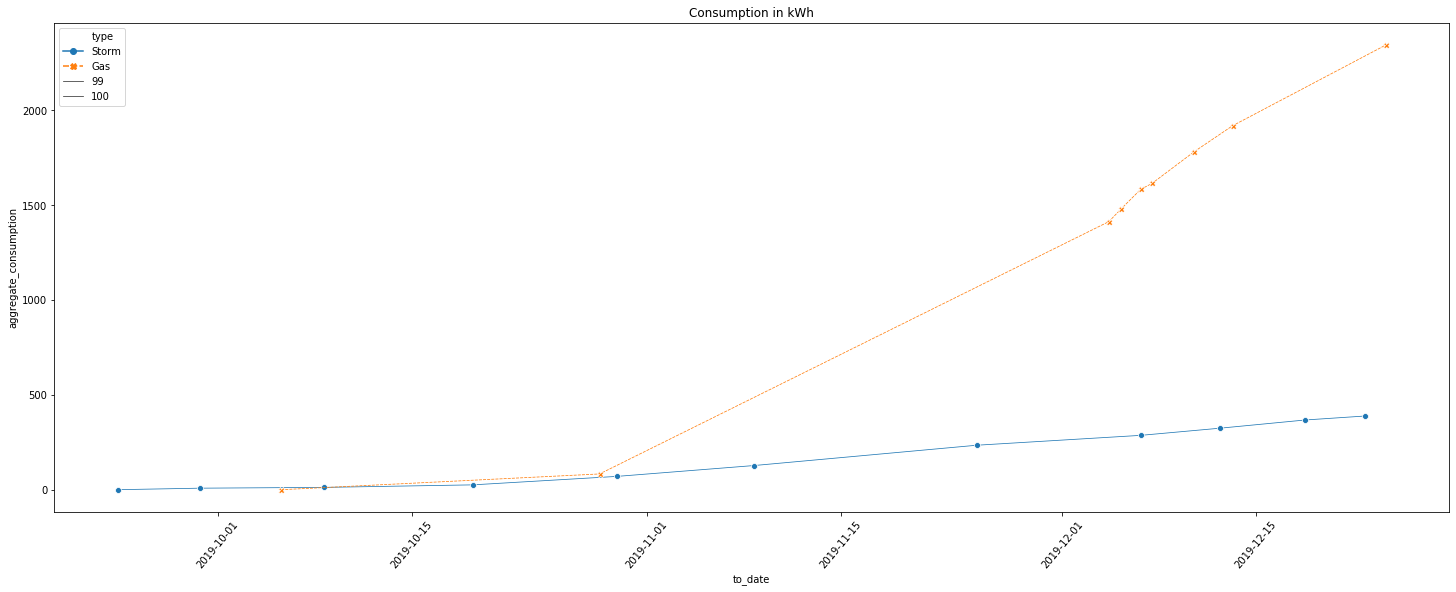

In [7]:
df_vis = df.copy()

plt.figure(figsize=(25, 9))
plt.title('Consumption in kWh')
plt.xticks(rotation=50)
sns.lineplot(data=df_vis, x=df_vis.index, y='aggregate_consumption', style="type", hue='type', markers=True, size=100)

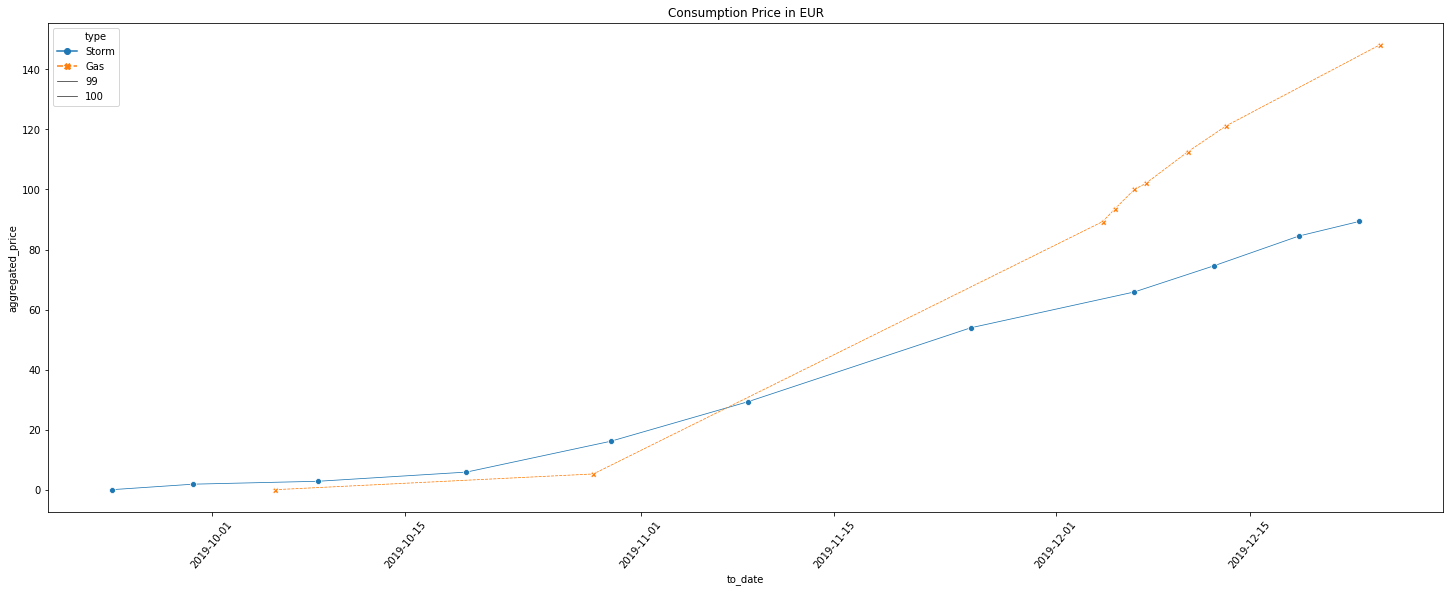

In [8]:
df_vis = df.copy()

plt.figure(figsize=(25, 9))
plt.title('Consumption Price in EUR')
plt.xticks(rotation=50)
sns.lineplot(data=df_vis, x=df_vis.index, y='aggregated_price', style="type", hue='type', markers=True, size=100)

## Analyisis
### Statistical features of `price` and `consumption`

In [9]:
df.groupby(['type'])[['consumption', 'price']].describe()

consumption                          ...   price                  
            count        mean         std  ...     50%       75%     max
type                                       ...                          
Gas           9.0  260.444444  419.736558  ...  6.4464  10.55440  84.056
Storm        12.0   32.366667   31.398099  ...  6.7850  10.70075  24.610

[2 rows x 16 columns]

### Total spensing on `price in EUR` and `consumption in kWh`

In [0]:
df.groupby(['type'])[['consumption', 'price']].sum()

,consumption,price
type,,
Gas,83.0,5.2456
Storm,234.4,53.9120


## Timeseries Analysis

In [0]:
consumption = df[df.type == 'Storm'].loc[:, ['consumption']].copy()
consumption

,consumption
to_date,
2019-09-23 18:37:00,0.0
2019-09-29 16:23:00,8.0
2019-10-08 16:36:00,4.2
2019-10-19 10:02:00,13.3
2019-10-29 20:17:00,44.7
2019-11-08 18:00:00,57.2
2019-11-08 18:00:00,0.0
2019-11-24 20:00:00,107.0


In [0]:
# df_sample = df[df.type == 'Storm'].resample(rule='1D').mean() / ((df[df.type == 'Storm']['seconds'] + 1) / 86400)
# df_sample
df_sample = df['price'] / ((df[df.type == 'Storm']['seconds'] + 1) / 86400)
df_sample = df_sample.resample(rule='1D').mean().interpolate('linear')
df_sample

to_date
2019-09-23        0.000000
2019-09-24        0.051916
2019-09-25        0.103832
2019-09-26        0.155749
2019-09-27        0.207665
                  ...     
2019-11-20    71043.630630
2019-11-21    53283.105511
2019-11-22    35522.580392
2019-11-23    17762.055273
2019-11-24        1.530154
Freq: D, Length: 63, dtype: float64

ValueError: ignored

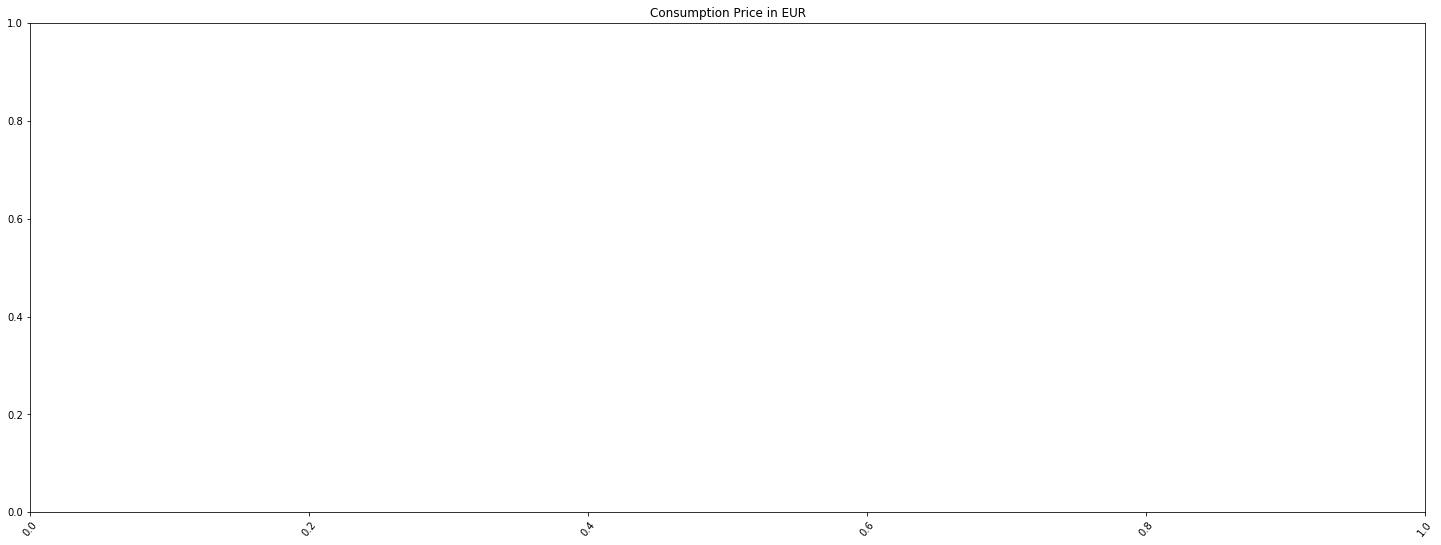

In [0]:
df_vis = df_sample.copy()

plt.figure(figsize=(25, 9))
plt.title('Consumption Price in EUR')
plt.xticks(rotation=50)
sns.lineplot(data=df_vis, x=df_vis.index, y='price', markers=True, size=100)